In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque


# Dueling DQN 网络
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        self.action_dim = action_dim
        
        # 共享特征提取层
        self.feature = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        # 状态价值流
        self.value_stream = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
        # 优势流
        self.advantage_stream = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim)
        )
    
    def forward(self, state):
        features = self.feature(state)
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        
        # 组合价值流和优势流
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values


# Dueling DQN 智能体
class DuelingDQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, 
                 epsilon_min=0.01, epsilon_decay=0.995, batch_size=64, memory_size=10000):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        
        # 创建策略网络和目标网络
        self.policy_net = DuelingDQN(state_dim, action_dim)
        self.target_net = DuelingDQN(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # 目标网络不进行梯度更新
        
        # 优化器
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        
        # 经验回放缓冲区
        self.memory = deque(maxlen=memory_size)
        
        # 日志记录
        self.loss_history = []
    
    def get_action(self, state):
        """根据当前状态选择动作（ε-贪婪策略）"""
        # 将状态归一化
        normalized_state = torch.tensor([state[0] / 14.0, state[1] / 19.0], dtype=torch.float32).unsqueeze(0)
        
        # ε-贪婪策略
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_dim)  # 随机动作
        else:
            with torch.no_grad():
                q_values = self.policy_net(normalized_state)
            return torch.argmax(q_values).item()  # 贪婪动作
    
    def get_greedy_action(self, state):
        """获取贪婪策略下的动作（用于评估）"""
        normalized_state = torch.tensor([state[0] / 14.0, state[1] / 19.0], dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = self.policy_net(normalized_state)
        return torch.argmax(q_values).item()
    
    def store_transition(self, state, action, reward, next_state, done):
        """存储转移经验"""
        self.memory.append((state, action, reward, next_state, done))
    
    def update_epsilon(self):
        """衰减ε值"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def replay(self):
        """从经验回放中学习"""
        if len(self.memory) < self.batch_size:
            return None  # 没有足够的数据进行学习
        
        # 从缓冲区随机采样一个批次
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # 转换为张量
        states_tensor = torch.tensor([(s[0]/14.0, s[1]/19.0) for s in states], dtype=torch.float32)
        actions_tensor = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states_tensor = torch.tensor([(s[0]/14.0, s[1]/19.0) for s in next_states], dtype=torch.float32)
        dones_tensor = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)
        
        # 计算当前Q值
        current_q_values = self.policy_net(states_tensor).gather(1, actions_tensor)
        
        # 计算目标Q值
        with torch.no_grad():
            next_q_values = self.target_net(next_states_tensor).max(1)[0].unsqueeze(1)
            target_q_values = rewards_tensor + self.gamma * next_q_values * (1 - dones_tensor)
        
        # 计算损失
        loss = F.mse_loss(current_q_values, target_q_values)
        
        # 更新网络
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # 记录损失
        self.loss_history.append(loss.item())
        
        return loss.item()
    
    def update_target_net(self):
        """更新目标网络"""
        self.target_net.load_state_dict(self.policy_net.state_dict())


In [30]:
# 训练
import os
import sys
from common_expand.gridworld import GridWorld

# 确保能够导入环境
if "common_expand" not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), "common_expand"))

# 创建环境
env = GridWorld()
state_dim = 2  # 二维状态 (行, 列)
action_dim = len(env.action_space)  # 4个动作

# 创建智能体
agent = DuelingDQNAgent(
    state_dim, 
    action_dim,
    lr=0.001,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995,
    batch_size=64,
    memory_size=10000
)

# 训练参数
episodes = 2000  # 训练轮数
max_steps_per_episode = 300  # 每回合最大步数
target_update_interval = 100  # 更新目标网络的间隔（步数）
replay_interval = 4  # 经验回放的间隔（步数）
log_interval = 100  # 打印日志的间隔

# 存储训练数据
data_root = "./data_dueling_DQN_3"
training_data_file = os.path.join(data_root, "Dueling_DQN_training_data.csv")
rewards_history = []  # 每个回合的总奖励
steps_history = []    # 每个回合的步数
loss_history = []     # 损失值

# 训练循环
for episode in range(1, episodes + 1):
    state = env.reset()
    done = False

    episode_loss = list()
    total_reward = 0
    step_count = 0
    
    while not done and step_count < max_steps_per_episode:
        # 选择动作
        action = agent.get_action(state)
        
        # 执行动作
        next_state, reward, done = env.step(action)
        
        # 存储转移经验
        agent.store_transition(state, action, reward, next_state, done)
        
        # 更新状态
        state = next_state
        total_reward += reward
        step_count += 1
        
        # 定期进行经验回放
        if step_count % replay_interval == 0:
            loss = agent.replay()
            if loss is not None:
                loss_history.append(loss)
        
        # 定期更新目标网络
        if step_count % target_update_interval == 0:
            agent.update_target_net()
    
    if episode == 500:
        print("添加惩罚状态(12, 16): -1.0")
        env.add_pits((12, 16))
    
    # 衰减ε值
    agent.update_epsilon()
    
    # 记录训练数据
    rewards_history.append(total_reward)
    steps_history.append(step_count)
    
    # 保存训练数据
    if not os.path.exists(training_data_file):
        os.makedirs(os.path.dirname(training_data_file), exist_ok=True)
        with open(training_data_file, "w") as f:
            f.write("episode,total_reward,step_count,loss,epsilon\n")
    
    with open(training_data_file, "a") as f:
        f.write(f"{episode},{total_reward},{step_count},{loss},{agent.epsilon}\n")
    
    # 打印训练进度
    if episode % log_interval == 0:
        avg_reward = np.mean(rewards_history[-log_interval:])
        print(f"Episode: {episode}, Avg Reward: {avg_reward:.2f}, Steps: {step_count}, Epsilon: {agent.epsilon:.4f}")

# 保存模型
# 修正为使用policy_net
model_save_path = os.path.join(data_root, "dueling_dqn_policy_net.pth")
torch.save(agent.policy_net.state_dict(), model_save_path)

# 同时保存目标网络（可选）
target_save_path = os.path.join(data_root, "dueling_dqn_target_net.pth")
torch.save(agent.target_net.state_dict(), target_save_path)


Episode: 100, Avg Reward: -0.05, Steps: 300, Epsilon: 0.6058
Episode: 200, Avg Reward: -0.06, Steps: 160, Epsilon: 0.3670
Episode: 300, Avg Reward: 1.12, Steps: 46, Epsilon: 0.2223
Episode: 400, Avg Reward: 1.67, Steps: 300, Epsilon: 0.1347
添加惩罚状态(12, 16): -1.0
Episode: 500, Avg Reward: 1.90, Steps: 35, Epsilon: 0.0816
Episode: 600, Avg Reward: 2.00, Steps: 33, Epsilon: 0.0494
Episode: 700, Avg Reward: 2.00, Steps: 68, Epsilon: 0.0299
Episode: 800, Avg Reward: 2.00, Steps: 33, Epsilon: 0.0181
Episode: 900, Avg Reward: 2.00, Steps: 33, Epsilon: 0.0110
Episode: 1000, Avg Reward: 2.00, Steps: 35, Epsilon: 0.0100
Episode: 1100, Avg Reward: 2.00, Steps: 33, Epsilon: 0.0100
Episode: 1200, Avg Reward: 2.00, Steps: 35, Epsilon: 0.0100
Episode: 1300, Avg Reward: 2.00, Steps: 33, Epsilon: 0.0100
Episode: 1400, Avg Reward: 2.00, Steps: 33, Epsilon: 0.0100
Episode: 1500, Avg Reward: 2.00, Steps: 33, Epsilon: 0.0100
Episode: 1600, Avg Reward: 2.00, Steps: 33, Epsilon: 0.0100
Episode: 1700, Avg Rewa

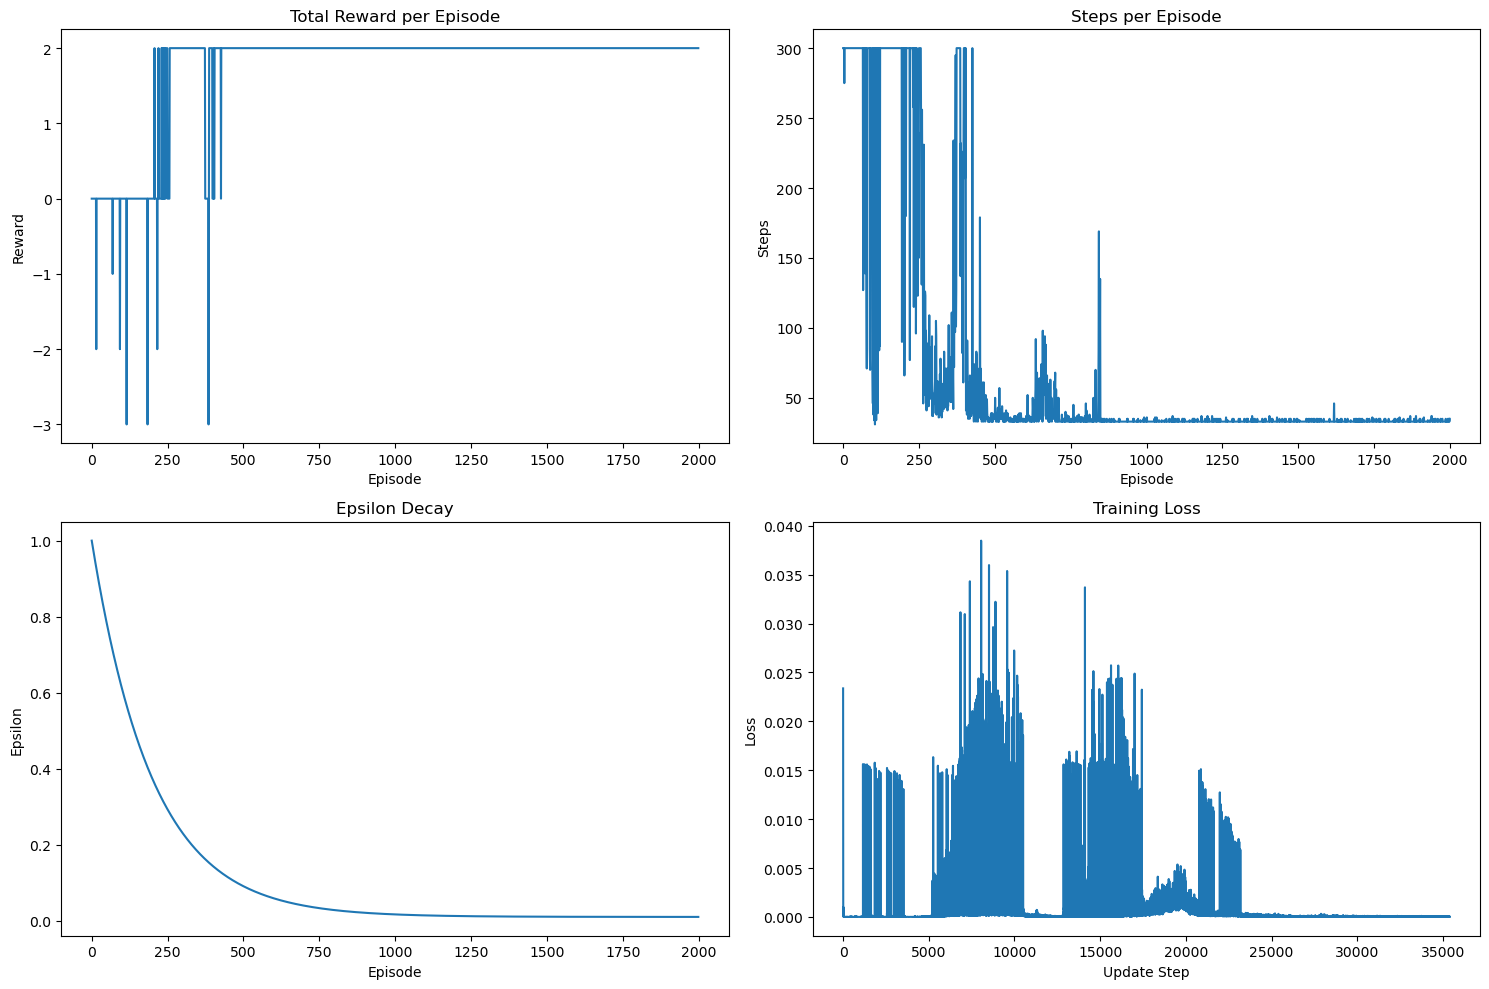


Optimal Policy from Dueling DQN:
State: (0, 0), Best Action: RIGHT
State: (0, 1), Best Action: RIGHT
State: (0, 5), Best Action: RIGHT
State: (0, 6), Best Action: RIGHT
State: (0, 10), Best Action: RIGHT
State: (0, 11), Best Action: RIGHT
State: (0, 12), Best Action: RIGHT
State: (0, 13), Best Action: RIGHT
State: (0, 14), Best Action: RIGHT
State: (0, 15), Best Action: RIGHT
State: (0, 16), Best Action: RIGHT
State: (0, 17), Best Action: RIGHT
State: (0, 18), Best Action: RIGHT
State: (0, 19), Best Action: RIGHT
State: (1, 0), Best Action: RIGHT
State: (1, 1), Best Action: RIGHT
State: (1, 2), Best Action: RIGHT
State: (1, 3), Best Action: RIGHT
State: (1, 4), Best Action: RIGHT
State: (1, 5), Best Action: RIGHT
State: (1, 6), Best Action: RIGHT
State: (1, 10), Best Action: RIGHT
State: (1, 11), Best Action: RIGHT
State: (1, 12), Best Action: RIGHT
State: (1, 13), Best Action: RIGHT
State: (1, 14), Best Action: RIGHT
State: (1, 15), Best Action: RIGHT
State: (1, 16), Best Action: UP


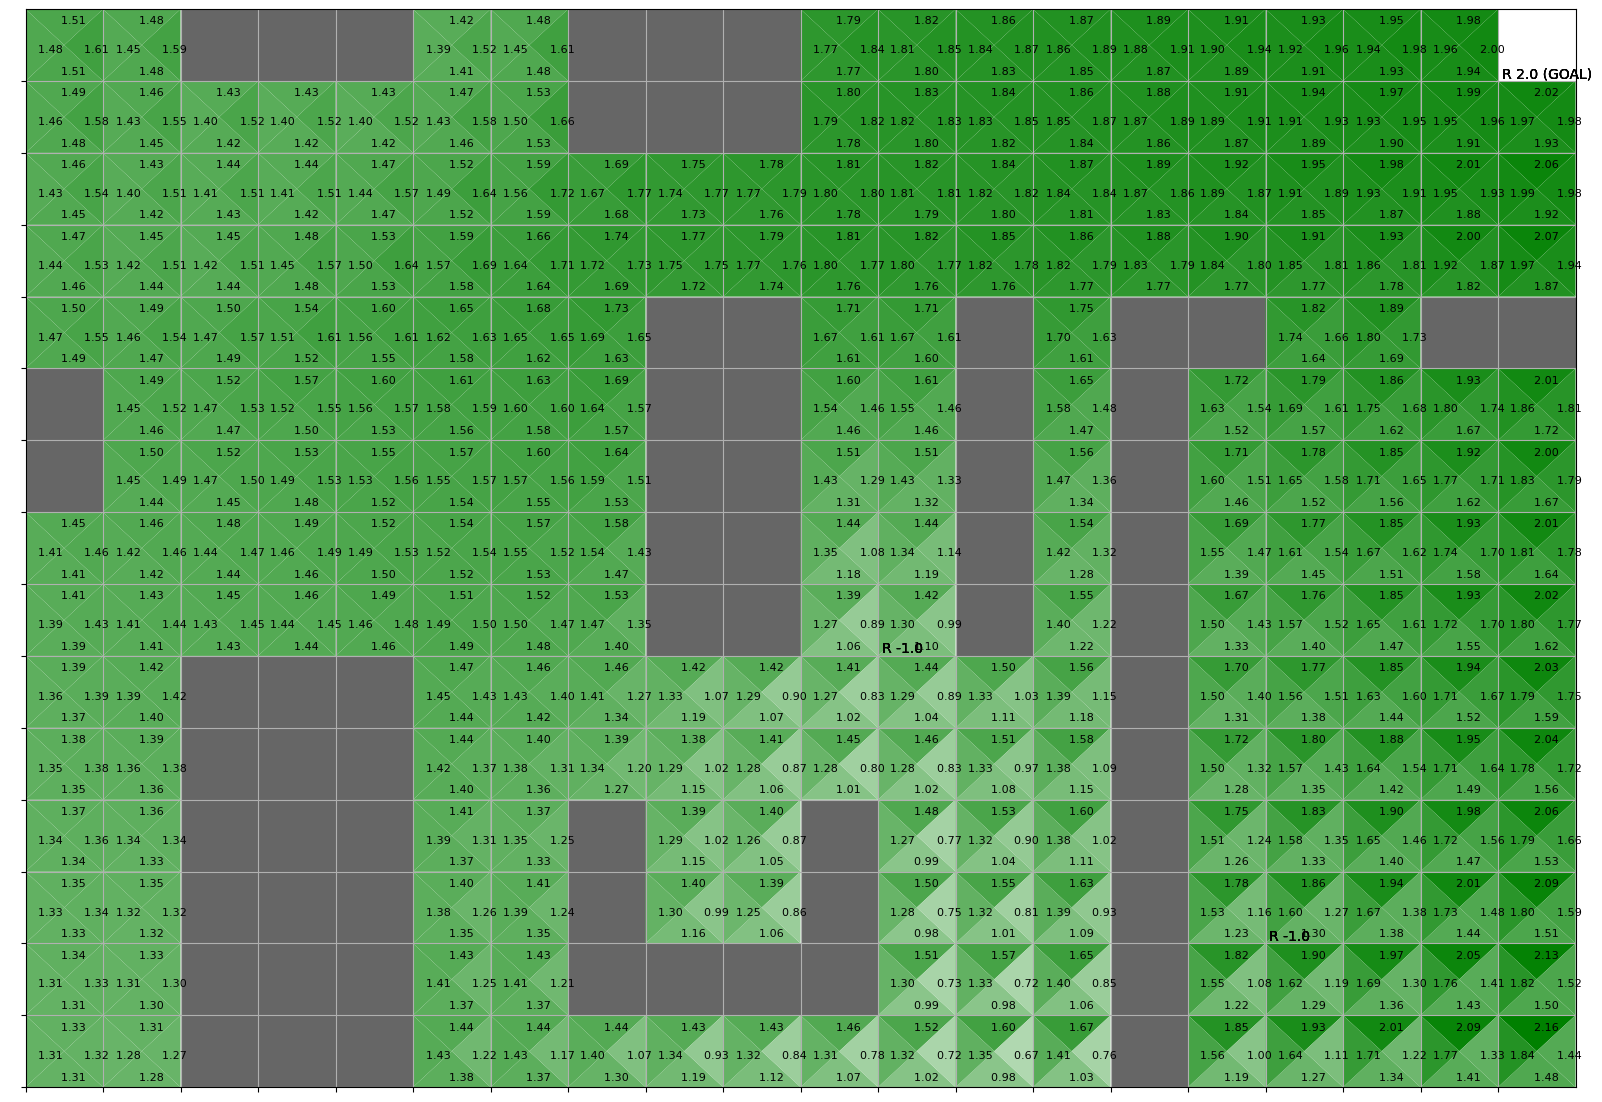

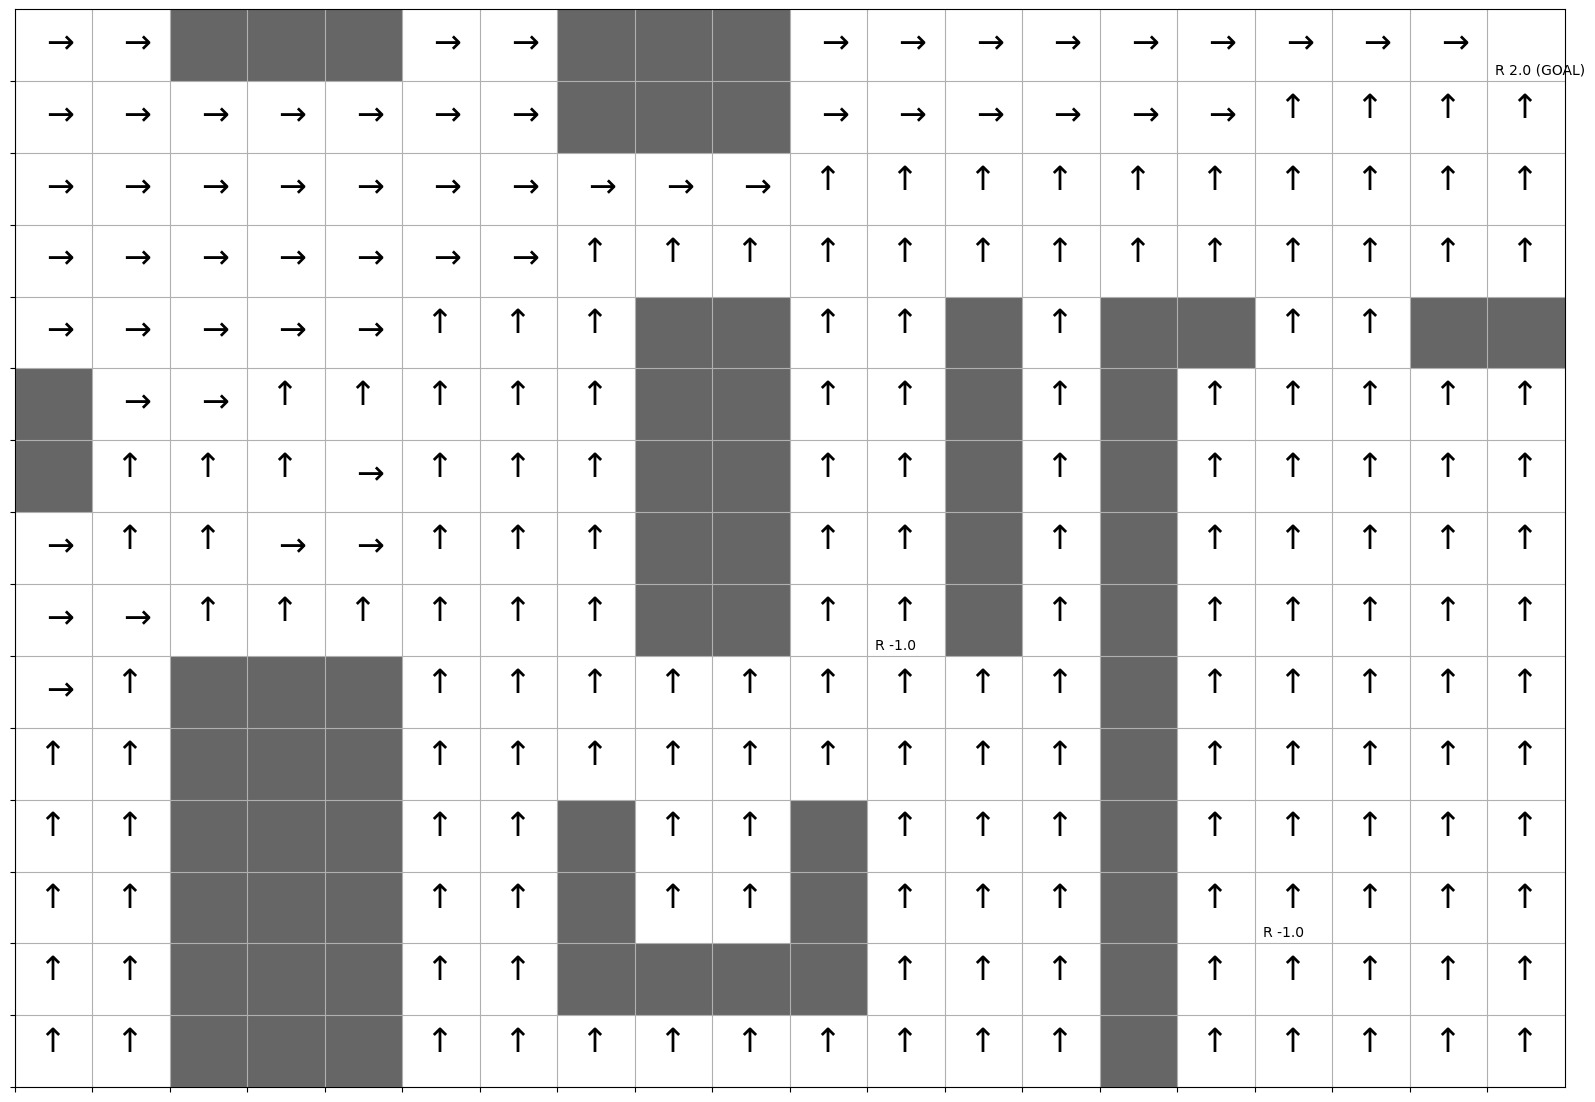

In [31]:
from matplotlib import pyplot as plt


# 可视化训练过程
plt.figure(figsize=(15, 10))

# 奖励曲线
plt.subplot(2, 2, 1)
plt.plot(rewards_history)
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

# 每回合的步数
plt.subplot(2, 2, 2)
plt.plot(steps_history)
plt.title("Steps per Episode")
plt.xlabel("Episode")
plt.ylabel("Steps")

# ε值变化
plt.subplot(2, 2, 3)
plt.plot([agent.epsilon_min + (1 - agent.epsilon_min) * agent.epsilon_decay**i for i in range(episodes)])
plt.title("Epsilon Decay")
plt.xlabel("Episode")
plt.ylabel("Epsilon")

# 损失曲线
plt.subplot(2, 2, 4)
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Update Step")
plt.ylabel("Loss")

plt.tight_layout()
plt.savefig("Dueling_DQN_training_results.png")
plt.show()


# 输出最优策略
print("\nOptimal Policy from Dueling DQN:")
for state in env.states():
    if state not in env.wall_state:  # 跳过墙状态
        normalized_state = torch.tensor([state[0]/14.0, state[1]/19.0], dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = agent.policy_net(normalized_state)
        best_action = torch.argmax(q_values).item()
        print(f"State: {state}, Best Action: {env.action_meaning[best_action]}")

# 创建 Q-table 用于渲染
q_table = {}
for state in env.states():
    if state not in env.wall_state:  # 跳过墙状态
        normalized_state = torch.tensor([state[0]/14.0, state[1]/19.0], dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = agent.policy_net(normalized_state)
        for action in range(4):
            q_table[(state, action)] = q_values[0, action].item()

# 渲染 Q 值
env.render_q(q_table)


In [32]:

# 评估最终策略的性能
test_episodes = 1000
success_count = 0
total_test_steps = 0

print("\nEvaluating final policy...")
for _ in range(test_episodes):
    state = env.reset()
    done = False
    step_count = 0
    
    while not done and step_count < max_steps_per_episode:
        action = agent.get_greedy_action(state)
        next_state, _, done = env.step(action)
        state = next_state
        step_count += 1
    
    if done and next_state == env.goal_state:
        success_count += 1
    total_test_steps += step_count

success_rate = success_count / test_episodes
avg_steps = total_test_steps / test_episodes

print(f"Success rate: {success_rate*100:.1f}%")
print(f"Average steps to goal: {avg_steps:.1f}")



Evaluating final policy...
Success rate: 100.0%
Average steps to goal: 33.0
